In [ ]:
#Mounts your Google Drive to a Colab notebook
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#unzip the file 
!unzip "/content/gdrive/MyDrive/tiny_Data.zip" -d /content/data

In [ ]:
# Set up the directory paths that will be used to load and preprocess the image data
path = "/content/data/tiny_Data/"
print(path)
data_dir = path
train_dir = "/content/data/Data_Small/train/DME"
test_dir = "/content/data/Data_Small/test/DME"

#Import libraries
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Add, Flatten, Dense, Conv2DTranspose, BatchNormalization, Reshape, PReLU, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
import numpy as np
import cv2
import PIL
from PIL import Image
from torchvision.transforms import Resize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import glob
from torchvision.transforms import Compose

/content/data/tiny_Data/


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None, high_res_transform=None):
        self.data_dir = data_dir
        self.transforms = transforms
        self.high_res_transform = high_res_transform
        self.img_paths = os.listdir(data_dir)

    def __getitem__(self, item):
        path = os.path.join(self.data_dir, self.img_paths[item])
        img = PIL.Image.open(path).convert('RGB')

        img_low = img
        img_high = img
        if self.transforms is not None:
            img_low = self.transforms(img)
        if self.high_res_transform is not None:
            img_high = self.high_res_transform(img)

        # Transpose axes of image tensor
        img_low = np.transpose(img_low, (1, 2, 0))
        img_high = np.transpose(img_high, (1, 2, 0))

        return (img_low, img_high)


    def __len__(self):
        return len(self.img_paths)

In [ ]:
#Defines three sets of data transformations
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor()
])

high_res_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#creates two PyTorch data loaders
batch_size = 32
train_dataset = MyDataset(train_dir, transforms=train_transforms, high_res_transform=high_res_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = MyDataset(test_dir, transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

1510
301


In [ ]:
#Builds a discriminator neural network model using the Keras API in TensorFlow.
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    layer_filters = [64, 128, 128, 256, 256, 512, 512]
    strides = [2, 1, 2, 1, 2, 1, 2]

    for filters, stride in zip(layer_filters, strides):
        x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='discriminator')
    return model

In [ ]:
#Building a generator model for a GAN
def build_generator(input_shape=(32, 32, 3)):
    inputs = Input(input_shape)
    
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(inputs)
    x = PReLU()(x)
    x1 = x
    
    # Residual blocks
    for _ in range(5):
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x1, x])
        x1 = x

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x1, x])

    # Upsampling
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU()(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU()(x)

    x = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    model = Model(inputs=inputs, outputs=x, name='generator')
    return model

In [ ]:
#Build two neural network models, a generator model and a discriminator model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   65536       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                          

In [ ]:
# Set the random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set training parameters
epochs = 65


# Build the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# Create the SRGAN model
input_shape = (32, 32, 3)
inputs = Input(input_shape)
high_res_fake = generator(inputs)
discriminator.trainable = False
validity = discriminator(high_res_fake)
srgan = Model(inputs, validity)

# Compile the SRGAN model
srgan.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy())

In [ ]:
# Define training loop
for epoch in range(epochs):
    num_batches = len(train_dataset) // batch_size
    for i in range(num_batches):
        batch_low_res = []
        batch_high_res = []
        
        for _ in range(batch_size):
            idx = np.random.randint(len(train_dataset))
            low_res_img, high_res_img = train_dataset[idx]
            
            batch_low_res.append(low_res_img.numpy())
            batch_high_res.append(high_res_img.numpy())

        batch_low_res = np.stack(batch_low_res)
        batch_high_res = np.stack(batch_high_res)

        # Train the discriminator
        high_res_fake = generator(batch_low_res)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(batch_high_res, real_labels)
        d_loss_fake = discriminator.train_on_batch(high_res_fake, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        real_labels = np.ones((batch_size, 1))
        g_loss = srgan.train_on_batch(batch_low_res, real_labels)

        # Print progress
        if i % 50 == 0:
            print(f"Epoch {epoch + 1}, Step {i}, Discriminator Loss: {d_loss[0]}, Discriminator Accuracy: {100 * d_loss[1]}, Generator Loss: {g_loss}")

    # Save model weights every 5 epochs
    if (epoch + 1) % 5 == 0:
        generator.save_weights(f"generator_epoch_{epoch + 1}.h5")
        discriminator.save_weights(f"discriminator_epoch_{epoch + 1}.h5")

Epoch 1, Step 0, Discriminator Loss: 9.803090631961823, Discriminator Accuracy: 29.6875, Generator Loss: 0.6406286954879761
Epoch 2, Step 0, Discriminator Loss: 2.3259069025151347e-05, Discriminator Accuracy: 100.0, Generator Loss: 0.121411994099617
Epoch 3, Step 0, Discriminator Loss: 9.724286844914332e-05, Discriminator Accuracy: 100.0, Generator Loss: 0.000134728237753734
Epoch 4, Step 0, Discriminator Loss: 8.096622252651287e-07, Discriminator Accuracy: 100.0, Generator Loss: 1.2663412540803165e-08
Epoch 5, Step 0, Discriminator Loss: 1.1976658527146355e-06, Discriminator Accuracy: 100.0, Generator Loss: 2.1549287961691865e-12
Epoch 6, Step 0, Discriminator Loss: 8.074131244484306e-06, Discriminator Accuracy: 100.0, Generator Loss: 5.596556165999291e-19
Epoch 7, Step 0, Discriminator Loss: 5.9987551139784046e-06, Discriminator Accuracy: 100.0, Generator Loss: 9.755644148137882e-22
Epoch 8, Step 0, Discriminator Loss: 9.582389969509109e-06, Discriminator Accuracy: 100.0, Generator L

1/1 [==============================] - 0s 27ms/step


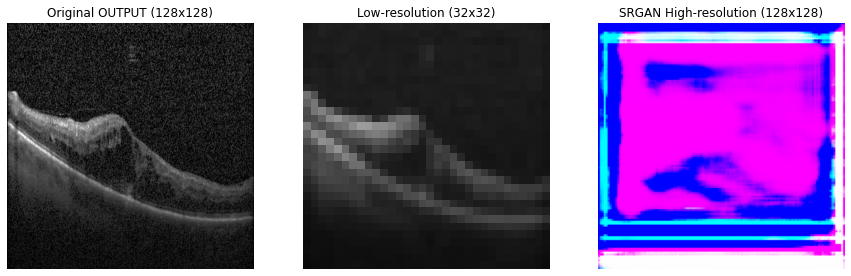

In [ ]:
import matplotlib.pyplot as plt

# Load a 32x32 image from the dataset
low_res_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = MyDataset('/content/data/Data_Small/train/DME/', transforms=low_res_transforms)
low_res_img, _ = dataset[0]

# Load the original high-resolution image
high_res_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

high_res_dataset = MyDataset('/content/data/Data_Small/train/DME/', transforms=high_res_transforms)
_, high_res_img = high_res_dataset[0]


# Prepare the low-resolution image for inference
low_res_img = low_res_img.unsqueeze(0)  # Add a batch dimension
low_res_img = low_res_img.numpy()  # Convert to numpy array

# Use the generator to upscale the 32x32 image to 128x128
high_res_fake = generator.predict(low_res_img)

# Display the 32x32 image, the upscaled 128x128 image and the original high-resolution image
low_res_img_display = low_res_img[0].transpose(0, 1, 2)
high_res_fake_display = high_res_fake[0].transpose(0, 1, 2)
high_res_img_display = high_res_img.transpose(2, 0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(high_res_img_display)
plt.title('Original OUTPUT (128x128)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(low_res_img_display)
plt.title('Low-resolution (32x32)')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(high_res_fake_display)
plt.title('SRGAN High-resolution (128x128)')
plt.axis('off')

plt.show()